In [1]:
import numpy as np
import tifffile
import glob
import os

from reco_helper import reconstruct_one_slice, get_spectrum

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm

In [2]:
before = np.load('/mnt/HD-LSDF/sd18a004/for_yaroslav/projections_681/proj_0.npy')
after = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/projections_681_processed/proj_0.npy')

In [3]:
before.shape, after.shape

((681, 512, 512), (679, 512, 512))

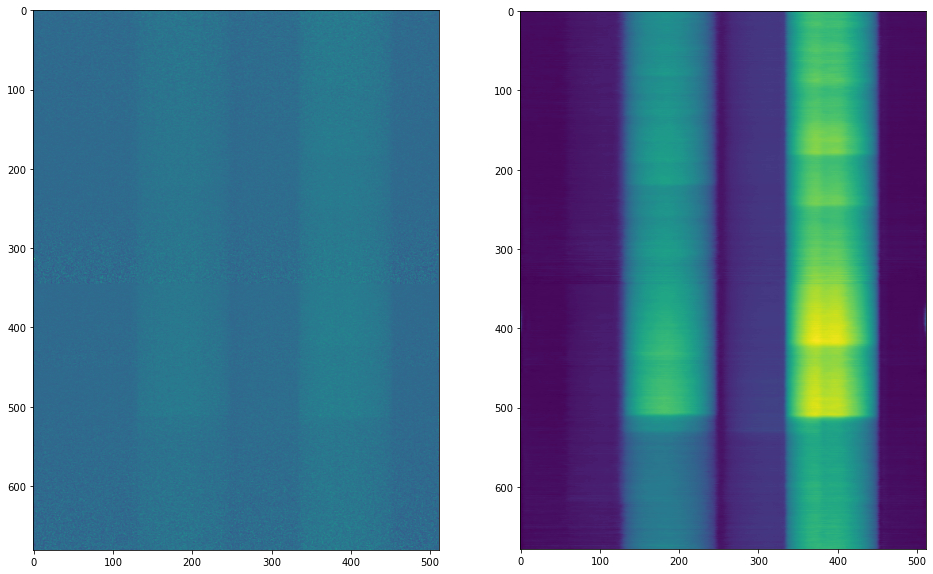

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))
ax1.imshow(before[:, 200])
ax2.imshow(after[:, 200])
plt.show()

In [6]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

In [7]:
slice_number = 127

sino_before = []
for i in tqdm(range(120)):
    sino_before.append(np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/projections_681/proj_{i}.npy', 
                               mmap_mode='r')[:, slice_number])
sino_before = np.stack(sino_before, axis=1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [8]:
reco_before = reconstruct_one_slice(sino_before, n_channels=681)

reconstructing channels:   0%|          | 0/681 [00:00<?, ?it/s]

In [9]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/projections_681_processed/proj_{i}.npy')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [10]:
reco_after = reconstruct_one_slice(sino_after, n_channels=sino_after.shape[0])

reconstructing channels:   0%|          | 0/679 [00:00<?, ?it/s]

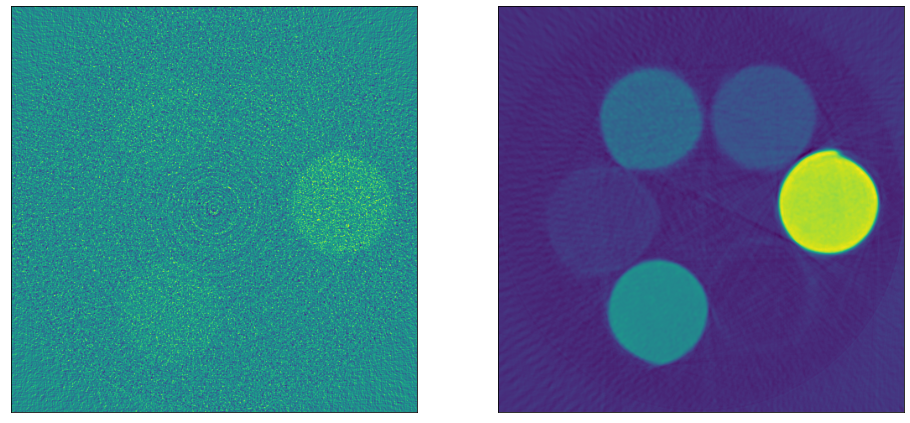

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))
ax1.imshow(reco_before[200])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(reco_after[200])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

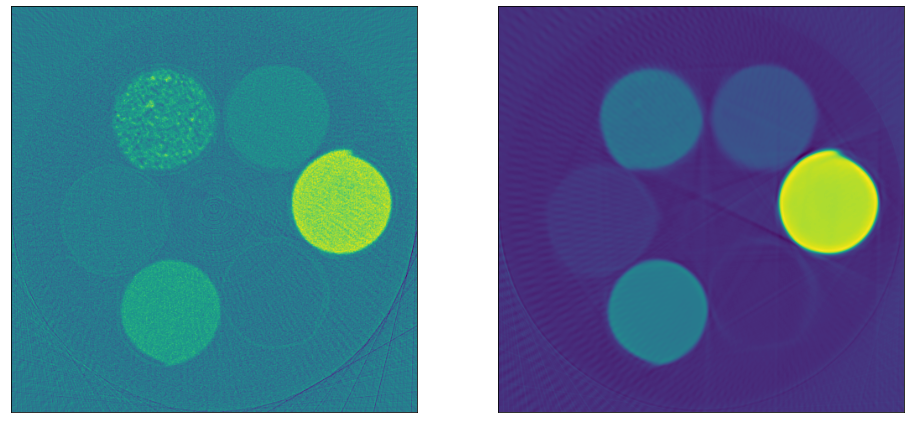

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))
ax1.imshow(reco_before.sum(0))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(reco_after.sum(0))
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

([], [])

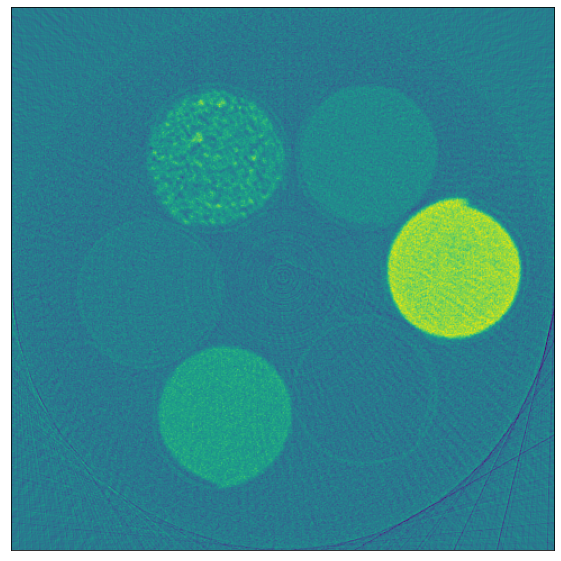

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(reco_before.sum(0))
plt.xticks([])
plt.yticks([])

In [16]:
reco_before.shape

(681, 484, 484)

In [14]:
reco_after = np.concatenate([reco_after[[0]], reco_after, reco_after[[-1]]])

In [ ]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

In [15]:
from skimage.metrics import peak_signal_noise_ratio

In [19]:
peak_signal_noise_ratio(reco_after[:, 250, 400], reco_before[:, 250, 400])

13.07287085427781

In [83]:
import csv
import sklearn.metrics
from matplotlib import pyplot as plt

def prepare_spectrum_points(reconstructed_slice=None, binning=[16, 8, 8, 4]):

    # parse specral info
    # shutter values
    tof_lim_left = np.array([15e-3, 27e-3, 44e-3, 53e-3])
    tof_lim_right = np.array([26.68e-3, 43.68e-3, 52.68e-3, 72e-3])
    tof_bin_width = np.array([10.24, 20.48, 20.48, 40.96])

    # number of shutter intervals
    n_intervals = 4

    # binning in each shutter interval
    binning = np.array(binning)

    # calculate number of bins in each shutter interval
    # TOF is in seconds, bins in microseconds
    n_bins = np.int_(np.floor((tof_lim_right - tof_lim_left) / (tof_bin_width * binning * 1e-6)))
    n_bins_total = np.sum(n_bins)

    ## prepare spectral axis for plots
    tof_bins_left = np.zeros((n_bins_total), dtype = np.float32)
    tof_bins_right = np.zeros((n_bins_total), dtype = np.float32)
    counter = 0
    for i in range(n_intervals):
        tof_bins_left[counter:(counter+n_bins[i])] = np.arange(tof_lim_left[i], tof_lim_right[i]-tof_bin_width[i]*binning[i]*1e-6, tof_bin_width[i]*binning[i]*1e-6, dtype = np.float32)
        tof_bins_right[counter:(counter+n_bins[i])] = tof_bins_left[counter:(counter+n_bins[i])] + (tof_bin_width[i]*binning[i]*1e-6)
        counter = counter+n_bins[i]

    tof_bins_center = ((tof_bins_left + tof_bins_right) / 2)

    l = 56.428
    # full equation
    # angstrom_lim_1 = (tof_lim_1 * const.h) / (const.m_n * l) * 1e10
    # angstrom_lim_2 = (tof_lim_2 * const.h) / (const.m_n * l) * 1e10
    # and it's simplified form
    angstrom_lim_1 = (tof_lim_left * 3957) / l
    angstrom_lim_2 = (tof_lim_right * 3957) / l
    angstrom_bins_center = (tof_bins_center * 3957) / l
    angstrom_bin_width = (tof_bin_width * 1e-6 * 3957) / l

    # import table data with attenuation values for different wavelength
    attenuation_zn = np.zeros((3974, 2), dtype=np.float32)
    with open('Zn_new.txt', 'r') as attenuation_values_csv:
        csv_reader = csv.reader(attenuation_values_csv, delimiter = '\t')
        
        # skip first row with column names
        next(csv_reader)
        counter = 0
        for row in csv_reader:
            
            attenuation_zn[counter, :] = row
            counter += 1

    attenuation = np.zeros((5998, 11), dtype = np.float32)
    with open('attenuation.txt', 'r') as attenuation_values_csv:
        csv_reader = csv.reader(attenuation_values_csv, delimiter = '\t')
        
        # skip first row with column names
        next(csv_reader)
        counter = 0
        for row in csv_reader:
            attenuation[counter, :] = row
            counter += 1

    # wavelength - first column
    wavelength = np.sort(np.copy(attenuation_zn[:, 0]))

    attenuation_zn = attenuation_zn[:, 1]
    # interpolate attenuation on common axis
    attenuation_tmp = np.interp(angstrom_bins_center, wavelength, attenuation_zn)
    attenuation_zn = np.copy(attenuation_tmp)
    attenuation_zn[-1] = attenuation_zn[-2]

    # wavelength - first column
    wavelength = np.copy(attenuation[:, 0])
    attenuation[:, :-1] = attenuation[:, 1:]
    # add a column with attenuation for air - currently zero
    attenuation[:, -1] = 0
    # column names
    materials = np.array(["Ti", "Fe", "Ni", "Cu", "Cd", "W", "Pb", "Al", "Zn", "ZnO", "Air"])

    # interpolate attenuation on common axis
    attenuation_tmp = np.zeros((n_bins_total,11), dtype = np.float32)

    for i in range(11):
        attenuation_tmp[:,i] = np.interp(angstrom_bins_center, wavelength, attenuation[:,i])

    attenuation = attenuation_tmp
    attenuation[:, 8] = attenuation_zn

    # set-up plots
    sample_materials = np.array(["Fe", "Ni", "Cu",  "Zn", "Al"])

    #green, orange, blue, black, terracota
    colors = [[44/255, 162/255, 95/255],\
              [227/255, 74/255, 51/255],\
              [44/255, 127/255, 184/255],\
              [99/255, 99/255, 99/255],\
              [191/255, 91/255, 23/255]]

    # this coefficients scale gray values 
    # the reason why we need to do this is because 
    # we used not solid materails but powders
    # i.e. each reconstucted voxel contains a mixture of
    # air and maetrial
    coeff = [0.65, 0.9, 0.55, 1, 0.9]

    # roi coordinates and size which we used to generate
    # spectral profiles
    # roi_row = np.array([362, 242, 120, 132, 252])
    # roi_col = np.array([182, 382, 150, 312, 100])

    roi_row = np.array([362, 242, 120, 132, 252])
    roi_col = np.array([182, 382, 150, 312, 100])

    roi_pix_v = 1
    roi_pix_h = 1

    nrows = 5
    ncols = 2
    
        
    if reconstructed_slice is not None:
        #%% plot results - spectral comparison
        # now it compares FBP vs FBP :) in your case I guess it will be FBP vs denoised FBP
        # scale pixel values
        FBP_recon = reconstructed_slice / 0.055
    
        predicted_lines = []
        for i in range(5):
            predicted_lines.append(1/coeff[i]*np.mean(np.mean(FBP_recon[:, roi_row[i]:(roi_row[i]+roi_pix_v), roi_col[i]:(roi_col[i]+roi_pix_h)], axis = 2), axis = 1))

    else:
        predicted_lines = []
        for i in range(5):
            predicted_lines.append(attenuation[:, materials == sample_materials[i]])
    
    return predicted_lines

In [95]:
tvtgvd = np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/pdhg_tv_tgv_alpha_0.0075_beta_0.3.npy')

In [96]:
tvtgvd.shape

(339, 460, 460)

In [85]:
th = prepare_spectrum_points(binning=[8, 4, 4, 2])

In [109]:
raw = prepare_spectrum_points(reconstructed_slice=reco_before[:, 12:-12, 12:-12], binning=[8, 4, 4, 2])

In [110]:
prc = prepare_spectrum_points(reconstructed_slice=reco_after[:, 12:-12, 12:-12], binning=[8, 4, 4, 2])

In [97]:
prc = prepare_spectrum_points(reconstructed_slice=tvtgvd)

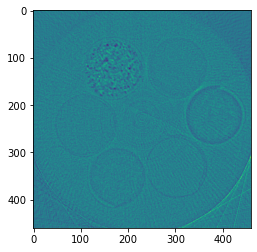

In [105]:
plt.imshow(tvtgvd.mean(0) - reco_before.mean(0)[12:-12, 12:-12])

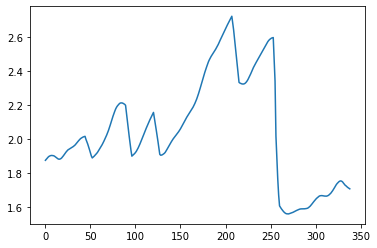

In [98]:
plt.plot(prc[1])

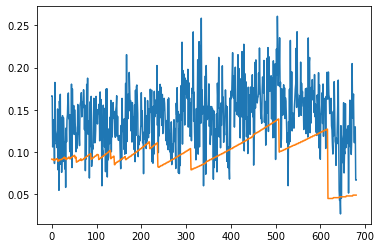

In [113]:
plt.plot(prc[4])
plt.plot(th[4])

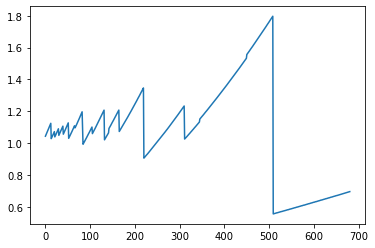

In [87]:
plt.plot(th[0])

In [74]:
roi_row = np.array([362, 242, 120, 132, 252])
roi_col = np.array([182, 382, 150, 312, 100])
coeff = [0.65, 0.9, 0.55, 1, 0.9]

In [59]:
from skimage.metrics import structural_similarity as ssim

In [61]:
att[0][:, att[1] == att[2][i]]

(681, 1)

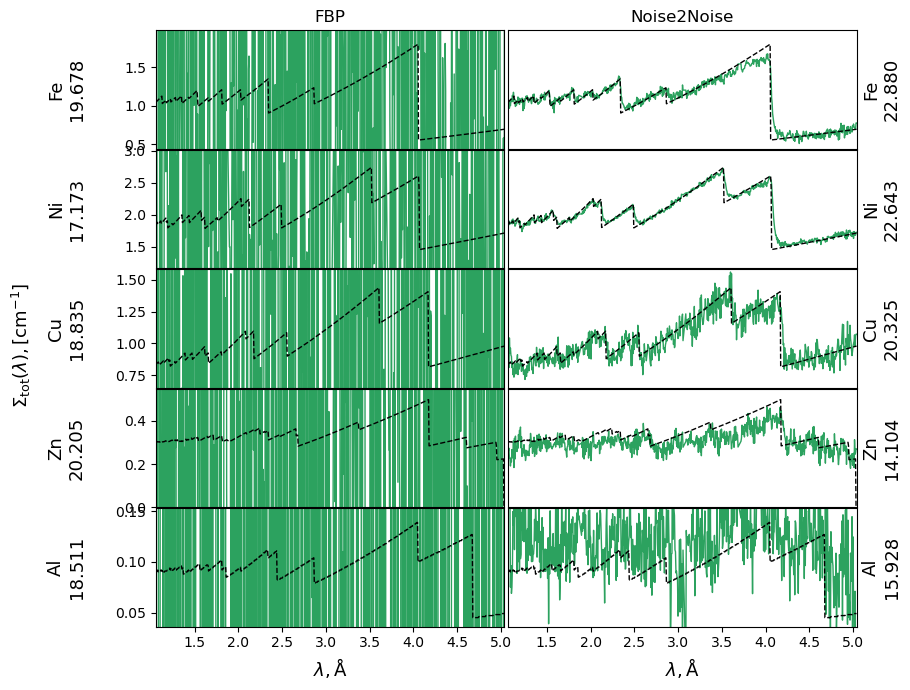

In [53]:
att = get_spectrum(reco_before, reco_after, binning=[8, 4, 4, 2], name_right='Noise2Noise')

In [23]:
%debug

> /home/ws/tb0536/anaconda3/lib/python3.9/site-packages/skimage/_shared/utils.py(569)check_shape_equality()
    567     """Raise an error if the shape do not match."""
    568     if not im1.shape == im2.shape:
--> 569         raise ValueError('Input images must have the same dimensions.')
    570     return
    571 

ipdb> 
ipdb> im1.shape
(681, 1)
ipdb> im2.shape
(681,)
ipdb> q
